In [ ]:
# credit to https://www.youtube.com/watch?v=pjtnkCGElcE
#https://towardsdatascience.com/multi-class-classification-with-transformers-6cf7b59a033a
#https://betterprogramming.pub/build-a-natural-language-classifier-with-bert-and-tensorflow-4770d4442d41
!pip install transformers

import pandas as pd
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer
from transformers import BertweetTokenizer
#from transformers import TFDistilBertForSequenceClassification


     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 61.4 MB/s 
     |████████████████████████████████| 3.3 MB 63.6 MB/s 
     |████████████████████████████████| 895 kB 73.4 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Daten laden, welche manuell gelabelt wurden***

Nur die wichtigsten Spalten werden für die weitere Verarbeitung berücksichtigt, um die Rechenleistung für die Verarbeitung zu senken.

In [ ]:

databert = pd.read_csv('/content/drive/My Drive/Manu Master/lstm/emotions_training.csv')
databert = pd.DataFrame(databert, columns= ['tweet_id','sentiment','author','content'])
databert = databert[databert.sentiment != ""]
databert = databert[['tweet_id','sentiment','author','content']]
databert = databert.dropna(subset=["sentiment"])
databert = databert.dropna(subset=["content"])

databert = databert[databert['sentiment'] != "empty"]
databert = databert.drop(['author'], axis = 1)
databert

,tweet_id,sentiment,content
0,1337742598153383936,anger,All respect to due process but why not give ap...
1,1338587622214610946,disgust,@dwain_campbell Unfortunately Hansard does not...
2,1338569634501554184,disgust,@SkyNews It is a new type of vaccine. That man...
3,1337967890578993155,disgust,@4everNeverTrump @tedcruz You were hatched in ...
4,1337949315508166663,disgust,#Pfizervaccine #PfizerBioNTech Why #Pfizer is ...
...,...,...,...
26188,1369075459351318532,disgust,#COVID19 supply terms with #RDIF demand #NDA p...
26189,1369065634529746947,anticipation,#SputnikV to get its Italian wings. https://t....
26190,1368978614188933131,disgust,@FineGael &amp; @fiannafailparty You wouldn't ...
26191,1368860004397297667,disgust,#EU medicines' regulator calls for refrain in ...


In [ ]:
databert = databert.sort_values(by=['content', 'tweet_id'])

***Gelabelte Daten von Semval in ähnlichem Format laden***

In [ ]:
databert1 = pd.read_csv('/content/drive/My Drive/Manu Master/dataset/datatraining.csv')
databert1 = databert1.drop(databert1.columns[[0]], axis=1)
databert1 = databert1.rename(columns={'ID': 'tweet_id', 'Tweet': 'content'})
databert1 = databert1[databert1['sentiment'] != "empty"]
databert1 = databert1.reindex(columns=['tweet_id','sentiment','content'])
databert1

,tweet_id,sentiment,content
0,1245178103573463040,disgust,"if ur reading this, it’s gonna be okay🤍 except..."
1,1245168067262345217,sadness,AP #COVID19 +ve - 58\nY'day &amp; Today - 35* ...
2,1245144784013910017,disgust,@Firedingo @ochreblue He spent weeks claiming ...
3,1245225646739111939,disgust,if anyone does a coronavirus April's fools pra...
4,1245145668378902528,anger,@MSNBC @MaddowBlog Still thought #coronavirus ...
...,...,...,...
2176,1245148680375730177,anticipation,This is the rain that will WASH AWAY the #covi...
2177,1245221355638992896,disgust,To one of my ex’s.. I hope you get the Corona ...
2178,1245211242236530688,disgust,If I see any “I have coronavirus” posts tomorr...
2179,1245185116810313728,surprise,RT @palewire: Our California coronavirus track...


In [ ]:
from sklearn.utils import shuffle
databert = shuffle(databert)
databert

,tweet_id,sentiment,content
3015,1348005855921365000,fear,It has been 26 hours since my 2nd COVID-19 Pfi...
2622,1344220528618385409,sadness,@vinod_d007 @Peston Sadly Probably Needed. The...
2075,1347709677040242690,anticipation,The Pfizer/BioNTech vaccine? OR The Moderna va...
3024,1348834476323975168,fear,Got that Dash 19 test in the morning. Hella ne...
3766,1351519294627196928,trust,Received 2nd dose of covid vaccine\nHoping for...
...,...,...,...
349,1341514789462421504,anticipation,Well I think it's clear we have a winner. #IQ...
3163,1349429240689778688,joy,Got my first #PfizerBioNTech #covid19 #vaccine...
2472,1349148634919497734,anticipation,It’s #PfizerBioNTech 95% efficacy or #moderna...
2600,1341625218201206784,sadness,#COVID19 mutation B.1.1.7 70% more contagious!...


In [ ]:
databert = pd.concat([databert,databert1],ignore_index=True)
databert = databert[databert['sentiment'] != ""]

***Die Spalte sent_label ist kategorisch von 0-7 Kategorien gekennzeichnet und die Ausgabe wird in numerische Werte umgewandelt***

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
databert = databert.groupby('sentiment').filter(lambda x : len(x) > 0)
databert['sent_label'] = labelencoder.fit_transform(databert['sentiment'])
databert['sentiment'] = databert['sentiment'].astype('category')
databert

,tweet_id,sentiment,content,sent_label
0,1348005855921365000,fear,It has been 26 hours since my 2nd COVID-19 Pfi...,3
1,1344220528618385409,sadness,@vinod_d007 @Peston Sadly Probably Needed. The...,5
2,1347709677040242690,anticipation,The Pfizer/BioNTech vaccine? OR The Moderna va...,1
3,1348834476323975168,fear,Got that Dash 19 test in the morning. Hella ne...,3
4,1351519294627196928,trust,Received 2nd dose of covid vaccine\nHoping for...,7
...,...,...,...,...
6331,1245148680375730177,anticipation,This is the rain that will WASH AWAY the #covi...,1
6332,1245221355638992896,disgust,To one of my ex’s.. I hope you get the Corona ...,2
6333,1245211242236530688,disgust,If I see any “I have coronavirus” posts tomorr...,2
6334,1245185116810313728,surprise,RT @palewire: Our California coronavirus track...,6


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


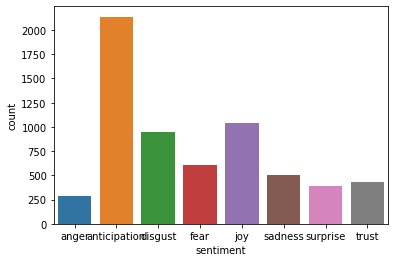

In [ ]:
import seaborn as sns
sns.countplot(databert['sentiment']) 

In [ ]:
List_Of_Categories_In_Column=list(databert['sent_label'].value_counts().index)
List_Of_Categories_In_Column

[1, 4, 2, 3, 5, 7, 6, 0]

In [ ]:
List_Of_Categories_In_Column=list(databert['sentiment'].value_counts().index)
List_Of_Categories_In_Column

In [ ]:
labelid= dict( enumerate(databert['sentiment'].cat.categories ) )

***Den Datensatz mit der Funktion sklearn shuffle mischen***

In [ ]:
from sklearn.utils import shuffle
databert = shuffle(databert)
databert = shuffle(databert)
databert

,tweet_id,sentiment,content,sent_label
5662,1245188735051927552,anticipation,Cuando acabe el coronavirus podemos decir esto...,1
5828,1245181722741944320,disgust,musicians need to stop being the almighty #cor...,2
5658,1247861430088372227,joy,@realDonaldTrump USA did 2Mn people testing ti...,4
3477,1353469188216672261,joy,Given my first dose of #PfizerBioNTech vaccine...,4
376,1342097448483876864,disgust,Also if mistyping Pfizer is the only side eff...,2
...,...,...,...,...
4350,1245168003853025280,sadness,I can't even sell my body because Corona. In f...,5
2964,1352878564690030592,anticipation,There’s no better tonic to reading anti vaccin...,1
5186,1245254432163606529,anticipation,When corona virus is over with I’m going to ea...,1
853,1349049214492422150,surprise,oh my god I’m actually getting the Pfizer vac...,6


***Preprocessing - Rechtschreibung, Punktuation***

In [ ]:
!pip install tweet-preprocessor
import preprocessor as p
p.set_options(p.OPT.MENTION, p.OPT.URL)
!pip install emoji
import emoji
#p.clean("hello guys @alx #sport🔥 1245 https://github.com/s/preprocessor")

     |████████████████████████████████| 184 kB 5.2 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=1520f9eac4396e68a5cf747cbf1b9b0116f84ee46e6f8b5406ec78738127460b
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji


In [ ]:
misspell_data = pd.read_csv("/content/drive/My Drive/Manu Master/lstm/aspell.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

In [ ]:
def punctuation(val): 
  
    punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
  
    for x in val.lower(): 
        if x in punctuations: 
            val = val.replace(x, " ") 
    return val

def misspelled_correction(val):
    for x in val.split(): 
        if x in miss_corr.keys(): 
            val = val.replace(x, miss_corr[x]) 
    return val

In [ ]:
databert["content"]=databert.content.apply(lambda x : p.clean(x))
databert["content"] = databert.content.apply(lambda x : ' '.join(punctuation(emoji.demojize(x)).split()))
databert["content"] = databert.content.apply(lambda x : misspelled_correction(x))

In [ ]:
databert

,tweet_id,sentiment,content,sent_label
5662,1245188735051927552,anticipation,Cuando acabe el coronavirus podemos decir esto...,1
5828,1245181722741944320,disgust,musicians need to stop being the almighty coro...,2
5658,1247861430088372227,joy,USA did 2Mn people testing till now for Corona...,4
3477,1353469188216672261,joy,Given my first dose of PfizerBioNTech vaccine ...,4
376,1342097448483876864,disgust,Also if mistyping Pfizer is the only side effe...,2
...,...,...,...,...
4350,1245168003853025280,sadness,I can t even sell my body because Corona In fa...,5
2964,1352878564690030592,anticipation,There’s no better tonic to reading anti vaccin...,1
5186,1245254432163606529,anticipation,When corona virus is over with I’m going to ea...,1
853,1349049214492422150,surprise,oh my god I’m actually getting the Pfizer vacc...,6


***Definieren der Sequenzlänge der Tweets. Es wurde 120 genommen, was mehr ist als die durchschnittliche Länge der Tweets nach dem Entfernen der Hyperlinks***

In [ ]:
import numpy as np
seq_len = 140
numb_samples = len(databert)
Xids = np.zeros((numb_samples,seq_len))
Xmask = np.zeros((numb_samples,seq_len))
Xids.shape

(6336, 140)

***Herunterladen des Bert-Tokenizers. Der BertTokenizer aus der vorinstallierten ("bert-base-uncased")-Version wird benutzt***

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")



for i, content in enumerate(databert['content']):
  tokens=tokenizer.encode_plus(content,max_length=seq_len,truncation=True,
                              padding='max_length',add_special_tokens=True,
                               return_tensors = 'tf')
  Xids[i,:]=tokens['input_ids']
  Xmask[i,:]=tokens['attention_mask']

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
Xmask

In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask,labels))
#dataset = tf.data.Dataset.from_tensor_slices(Xids, Xmask)
#dataset = tf.data.Dataset.from_tensor_slices(Xids,Xmask)
dataset.take(1)


<TakeDataset shapes: ((140,), (140,), (8,)), types: (tf.float64, tf.float64, tf.float64)>

In [ ]:
labels[:].shape

(6336, 8)

In [ ]:
def map_func(input_ids,masks,lables):
  return {'input_ids':input_ids,'attention_mask': masks},lables

In [ ]:
dataset = dataset.map(map_func)

In [ ]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (140,), attention_mask: (140,)}, (8,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [ ]:
#batch_size =16
batch_size =24
dataset = dataset.shuffle(1500).batch(batch_size,drop_remainder=True)

In [ ]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (24, 140), attention_mask: (24, 140)}, (24, 8)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [ ]:
split = 0.8
#split = 0.15
size = int((numb_samples / batch_size) * split)
print (size)

211


In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)
#del dataset

In [ ]:
len(val_ds)

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-uncased')

bert.summary()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:

input_ids = tf.keras.layers.Input(shape=(seq_len,),name='input_ids',dtype = 'int32')
mask = tf.keras.layers.Input(shape=(seq_len,),name='attention_mask',dtype = 'int32')
embeddings = bert.bert(input_ids, attention_mask=mask)[0]
x = tf.keras.layers.LSTM(140)(embeddings)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
X = tf.keras.layers.Dropout(0.1)(x)

y = tf.keras.layers.Dense(arr.max()+1,activation = 'softmax',name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids,mask],outputs=y)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 140)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 140)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 140)          509040      bert[0][0]                   

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
optimizer = Adam(
    learning_rate=1e-5,
    epsilon=1e-06,
    decay=1e-6,
    clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

In [ ]:
model.compile(optimizer,loss=loss,metrics=[acc])

In [ ]:
from keras.callbacks import ModelCheckpoint
model_save = ModelCheckpoint('/content/drive/My Drive/Manu Master/bert/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5', 
                             save_best_only = True,
                             save_weights = True, 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             verbose = 1)

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=20,batch_size=16,callbacks = [model_save])

Epoch 1/20
211/211 [==============================] - 968s 5s/step - loss: 1.7580 - accuracy: 0.4023 - val_loss: 1.4316 - val_accuracy: 0.5802

Epoch 00001: val_loss improved from inf to 1.43157, saving model to /content/drive/My Drive/Manu Master/bert/my_best_model.epoch01-loss1.43.hdf5
Epoch 2/20
211/211 [==============================] - 954s 5s/step - loss: 1.1919 - accuracy: 0.5942 - val_loss: 0.9846 - val_accuracy: 0.6737

Epoch 00002: val_loss improved from 1.43157 to 0.98457, saving model to /content/drive/My Drive/Manu Master/bert/my_best_model.epoch02-loss0.98.hdf5
Epoch 3/20
211/211 [==============================] - 950s 5s/step - loss: 0.9839 - accuracy: 0.6607 - val_loss: 0.8109 - val_accuracy: 0.7248

Epoch 00003: val_loss improved from 0.98457 to 0.81086, saving model to /content/drive/My Drive/Manu Master/bert/my_best_model.epoch03-loss0.81.hdf5
Epoch 4/20
211/211 [==============================] - 950s 5s/step - loss: 0.8218 - accuracy: 0.7145 - val_loss: 0.6648 - val

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


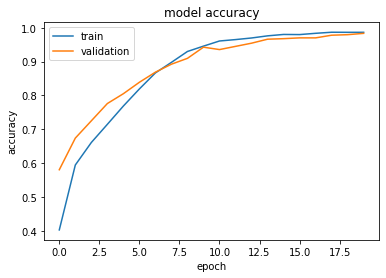

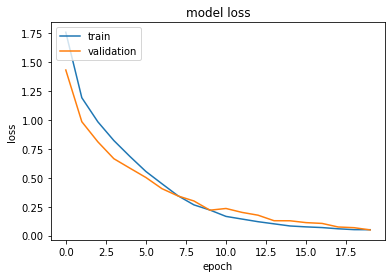

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

# serialize weights to HDF5
model.save("/content/drive/My Drive/Manu Master/bert/modelbert2f.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import tensorflow as tf
# load weights into new model
newmodel = tf.keras.models.load_model("/content/drive/My Drive/Manu Master/bert/modelbert2f.h5")


#loaded_tweet_model.load("/content/drive/My Drive/Manu Master/bert/modelbert2f.h5")
print("Loaded model from disk")
newmodel.summary()

In [ ]:
newmodel.compile(optimizer,loss=loss,metrics=[acc])

In [ ]:
history = newmodel.fit(train_ds,validation_data=val_ds,epochs=10,batch_size=16,callbacks = [model_save])

In [ ]:
import tensorflow as tf

In [ ]:
newmodel = tf.keras.models.load_model("/content/drive/My Drive/Manu Master/bert/modelbert2f.h5",compile = False)
#newmodel._make_train_function()
#with open('/content/drive/My Drive/Manu Master/bert/optimizer.pkl', 'rb') as f:
#    weight_values = pickle.load(f)
#newmodel.optimizer.set_weights(weight_values)

newmodel.summary()

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizer.encode_plus(text, max_length=140,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids']),
            'attention_mask': tf.cast(tokens['attention_mask'])}

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm
#dataqlabel = pd.read_csv('/content/drive/My Drive/Manu Master/lstm/emotions_training.csv',nrows=300)
#dataq = pd.read_csv('/content/drive/My Drive/Manu Master/cleandatatweetsappended.csv')
with tqdm(total=dataqlabel.shape[0]) as pbar: 
  for i, row in dataqlabel.iterrows():
    #print(f"Index: {i}")
    #print(f"{row['text']}")
    prd_sentences = dataqlabel.at[i,'content']
    tf_batchtext = tokenizer(prd_sentences, max_length=140,padding='max_length',truncation=True, return_tensors='tf')
    text_ips=tf_batchtext['input_ids'] 
    text_masks=tf_batchtext['attention_mask']
    predicted = model.predict([text_ips,text_masks])
    pred_labels = np.argmax(predicted)
    labeltoid={4:'joy',7:'trust',1:'anticipation',2:'disgust',0:'anger',3:'fear',5:'sadness',6:'surprise'}
    #label2id={0:'joy',1:'anger',2:'anticipation',3:'disgust',4:'trust',5:'fear',6:'sadness',7:'surprise'}
    dataqlabel.at[i, "bert_emotion"] =  labeltoid[np.argmax(predicted)]
    #print(pred_labels)
    pbar.update()

100%|██████████| 7518/7518 [25:52<00:00,  4.84it/s]


In [ ]:
import os
del dataqlabel['content']
#fllabel = 'ggeolocation_df1.csv'
fllabel1 = '/content/drive/My Drive/Manu Master/test/'+fllabel
dataqlabel.to_csv(fllabel1,index=False) 

In [ ]:
dataqlabel[:50]

,user_name,user_location,user_description,user_created,user_verified,date,text,Hashtags,is_retweet,bert_emotion
0,XYZ,"Melbourne, Victoria",Now is the time for change: \n\nIt's your XYZ,2015-01-21 04:35:41,False,2021-08-22 00:23:48,It is claimed that the three schoolchildren wh...,['COVIDVaccination'],False,sadness
1,#1u1Humanity,Earth,Exploring the spaces we all share...,2020-06-22 15:13:20,False,2021-08-22 00:22:58,"@DreaHumphrey 👍Clinical trials end in 2023, on...",NaN,False,anticipation
2,₿TC ya later,Event Horizon,₿TC - buy as much as you'd like.\nYou came. I ...,2021-05-09 14:47:20,False,2021-08-22 00:15:24,How can you possibly still think #Pfizer will ...,['Pfizer'],False,surprise
3,BringBackMorals,Tussen Hier en Daar,Neem het zoals het komt,2011-02-03 15:18:08,False,2021-08-22 00:08:19,"The contract is not with me, I didn t know so ...","['PFIZERLEAK', 'Pfizer', 'Covid_19', 'Corona']",False,disgust
4,Throw Away Alien,On your mind,NaN,2021-06-11 11:36:22,False,2021-08-22 00:07:42,@RWMaloneMD Do medications #ivermectin #flutic...,"['ivermectin', 'fluticasone', 'fluvoxamine']",False,fear
5,Mayank Grover,Deccans of India,"Pure unadulterated ramblings, fortified with t...",2017-05-27 08:16:16,False,2021-08-22 00:04:55,"On 29th May 2,713,209 were vaccinated, most by...",['Covishield'],False,surprise
6,Daddy Deyo,"Anaheim, CA","I'm a Rancho Cucamonga Quakes (@rcquakes) fan,...",2009-07-08 21:47:33,False,2021-08-22 00:04:18,It's not a choice.\n\nIt's a responsibility. \...,"['DontBeAPrick', 'GetTheShot', 'Covid_19', 'Co...",False,disgust
7,☂️deanjonesart,"London, England",It's the distance inbetween two objects which ...,2015-01-21 23:07:45,False,2021-08-22 00:00:51,@BelindaJones68 @David_Speers From your poster...,"['London', 'AstraZeneca', 'VaccinePassports', ...",False,anticipation
8,Julie Moore,"Oakdale, Ca",Mom/Wife/Educator. Animal lover. SFGiants fan....,2013-07-14 23:06:39,False,2021-08-22 00:00:42,@dogcelebration Guinness is helping me as I de...,['COVIDVaccination'],False,joy
9,Forbes Middle East,"309,B No 4, Emaar Busines Park",The Homepage of The World's #Business Leaders....,2020-06-25 15:35:43,True,2021-08-22 00:00:00,The #US Food and Drug Administration is expect...,"['US', 'Pfizer', 'BioNTech', 'COVID19', 'vacci...",False,anticipation
